# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

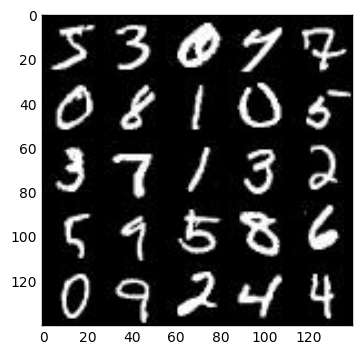

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

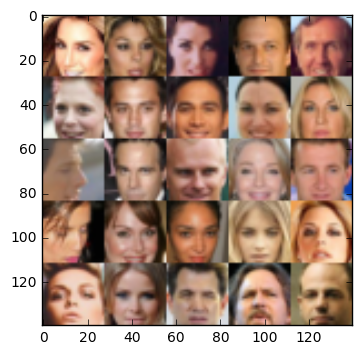

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\duzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(0.2 * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.3 * x3, x3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_images *= 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0754... Generator Loss: 10.6962
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 5.1018
Epoch 1/2... Discriminator Loss: 6.7908... Generator Loss: 0.0153
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 2.8807... Generator Loss: 0.1014
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.8867
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 2.5125... Generator Loss: 3.3782
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.3937


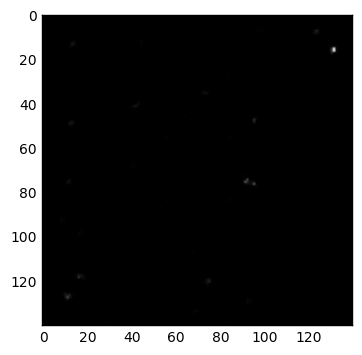

Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.3399
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 1.9259
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.3343
Epoch 1/2... Discriminator Loss: 1.7870... Generator Loss: 0.2890
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.3521
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 2.5855
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 1.0745


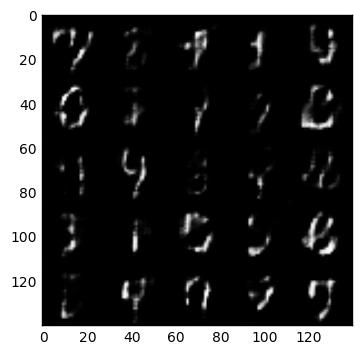

Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.4319
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.9827... Generator Loss: 0.1861
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.0660


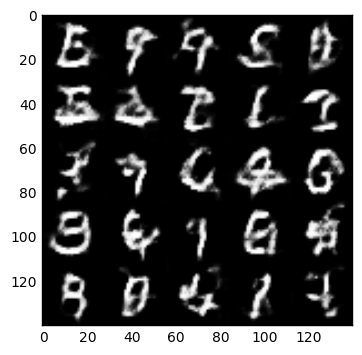

Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.4958
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.9582
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.5604
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.5541
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.7186


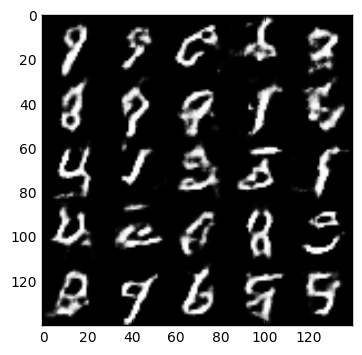

Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 1.4605
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.6555


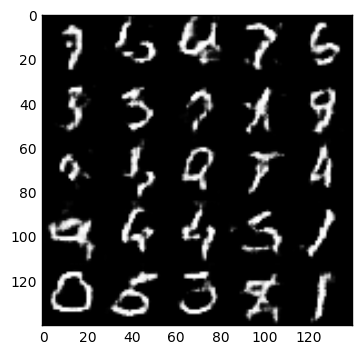

Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 1.8883
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.8396... Generator Loss: 2.0168
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.2982
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.3816
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.7326


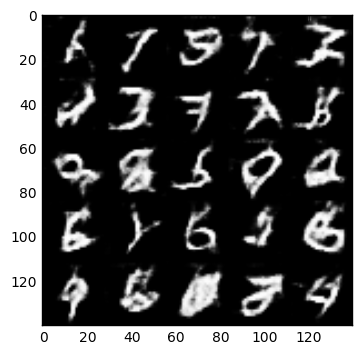

Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 1.6559
Epoch 1/2... Discriminator Loss: 1.6881... Generator Loss: 2.3310
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 1.6362... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7052


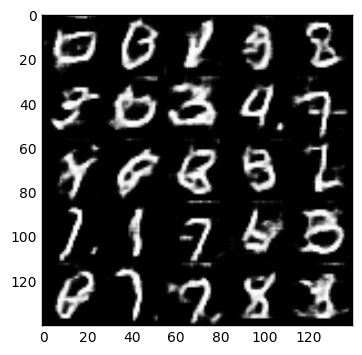

Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.2353
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.6624


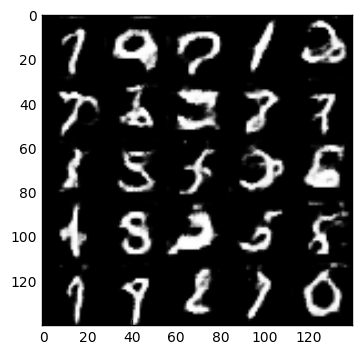

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.7075
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.3837
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.5357
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.0615
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 0.8424


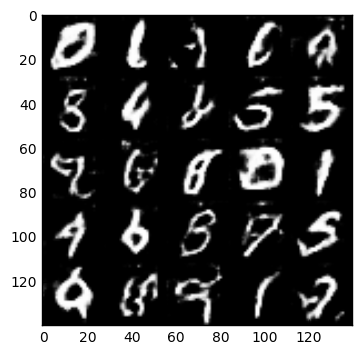

Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 1.6680... Generator Loss: 0.2808
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.1936


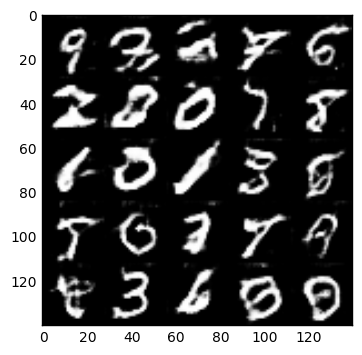

Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.0478
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 1.3649


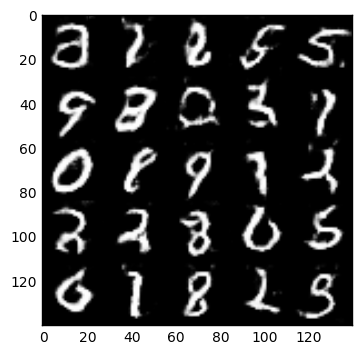

Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.5559
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.1184
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 1.1601
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.5228


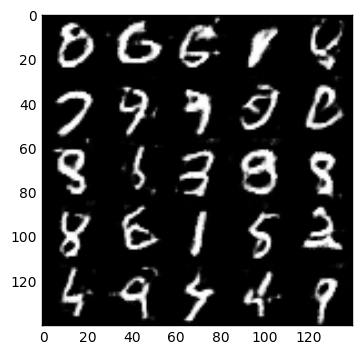

Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.9067... Generator Loss: 0.2259
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 2.0109
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.5496
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.9240


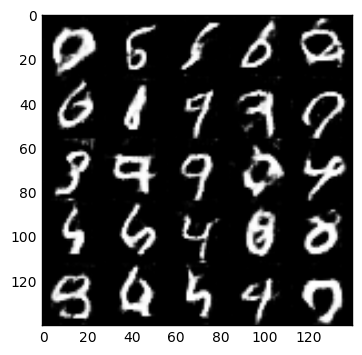

Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 2.5455... Generator Loss: 2.9190
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 1.5209
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7791


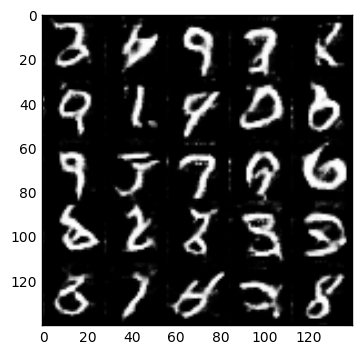

Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 1.9430... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.6926... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.3621
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.4976
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.8929


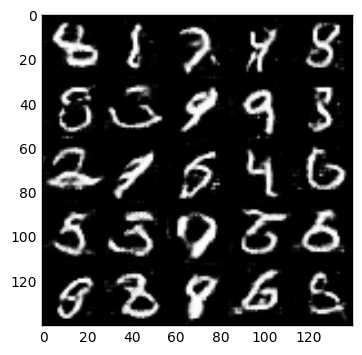

Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 1.6462... Generator Loss: 0.4080
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 2.1194
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 0.6946


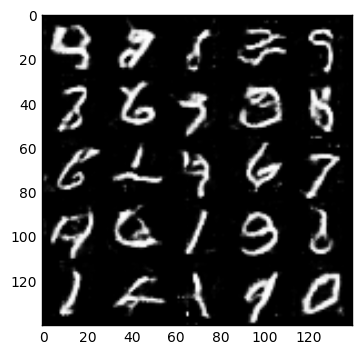

Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 1.1257
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.3499
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 2.1166
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 0.4135... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.1974... Generator Loss: 0.5112


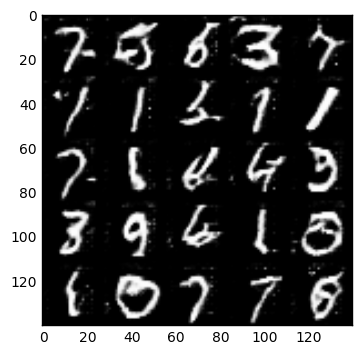

Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.8138
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 1.6337
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 2.0670
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.2054
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6761


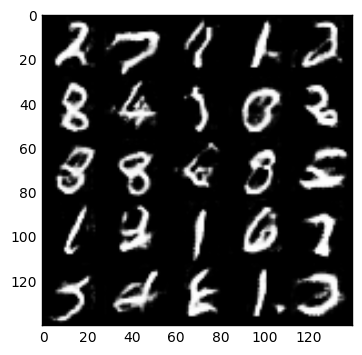

Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.2300
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.4147
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 1.3130
Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.5903


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 19.2720
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 2.2979
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 7.1958
Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 2.9061
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 5.3588
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 3.4660
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 2.8261


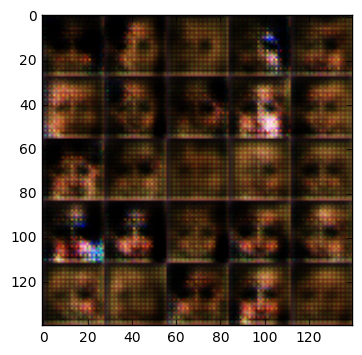

Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 2.4528
Epoch 1/1... Discriminator Loss: 2.7046... Generator Loss: 4.7712
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.7870
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 2.9996
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.9096... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 1.8099
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.5321


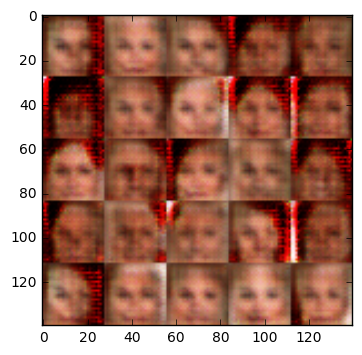

Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 1.8741
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.2219
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.8346


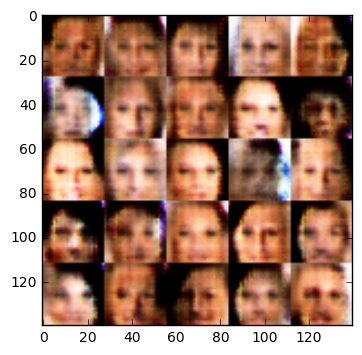

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.9954... Generator Loss: 0.1841
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.6820... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7511


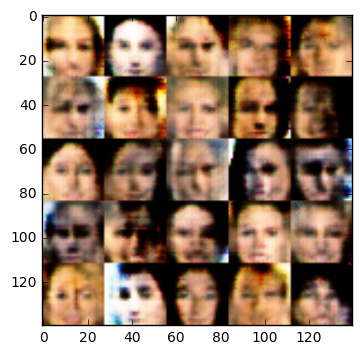

Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9989


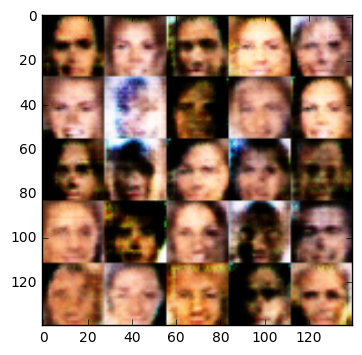

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5218


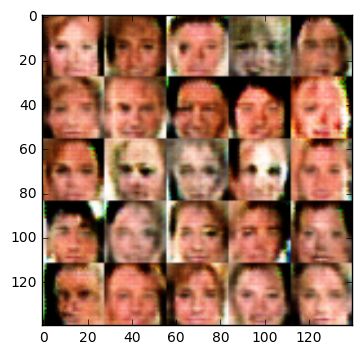

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6375


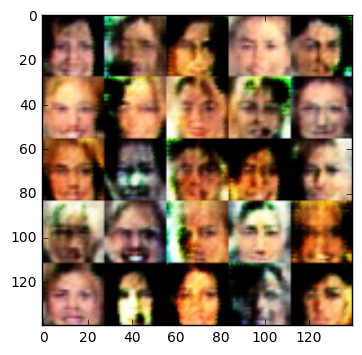

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 2.3033... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5508


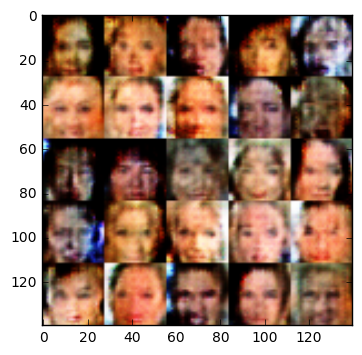

Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8644


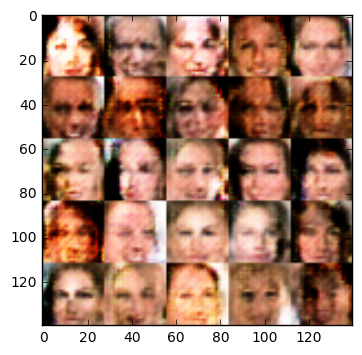

Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.8492


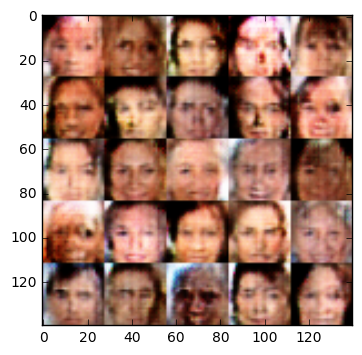

Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7347


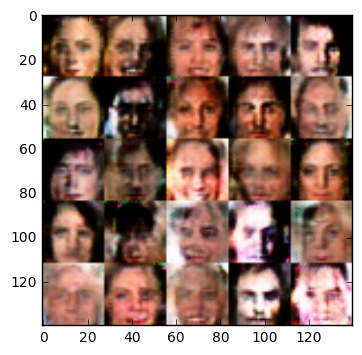

Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6963


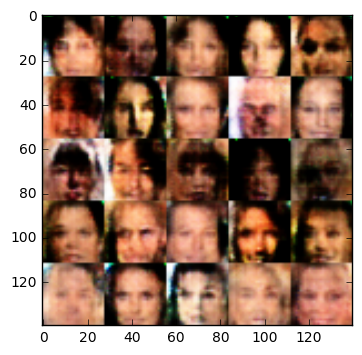

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6317


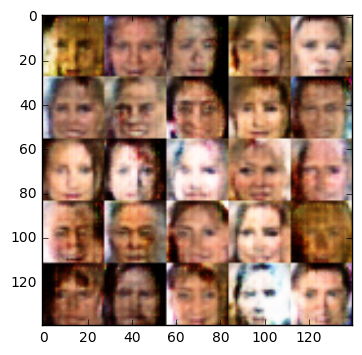

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.7037... Generator Loss: 1.6651
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.7374... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 1.2362


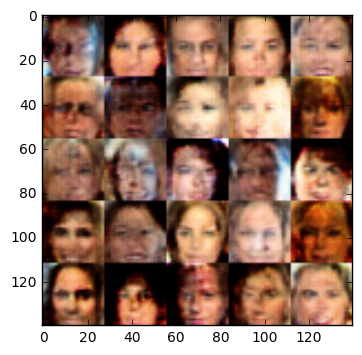

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7454


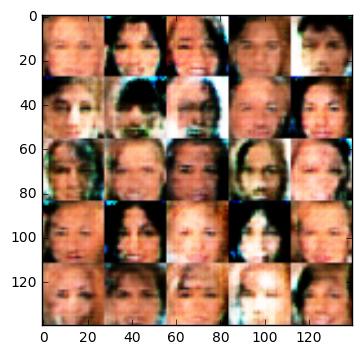

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8501


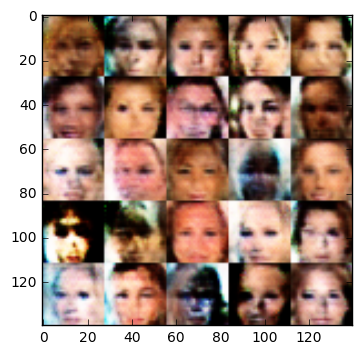

Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.5775


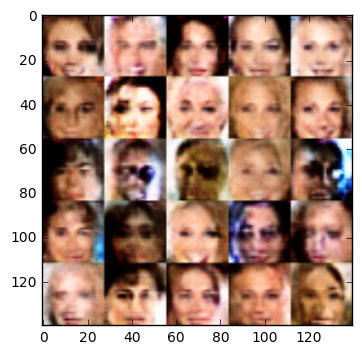

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.6295... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5190


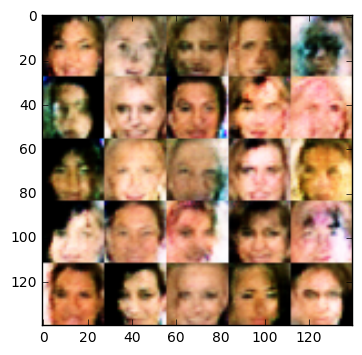

Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.8546... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6919


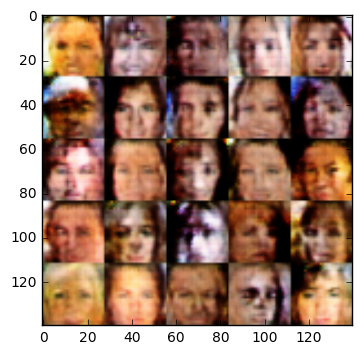

Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4390


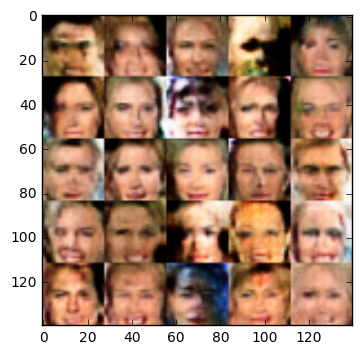

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7857


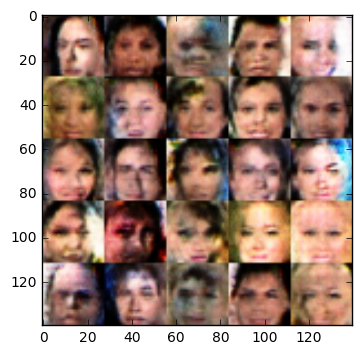

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 1.1678


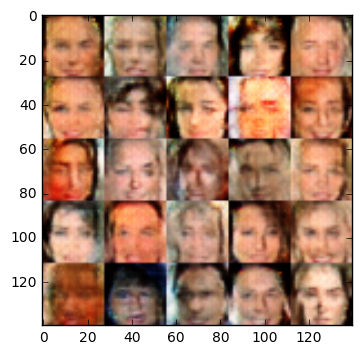

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8181


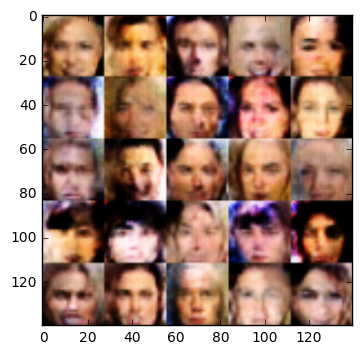

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 1.2916


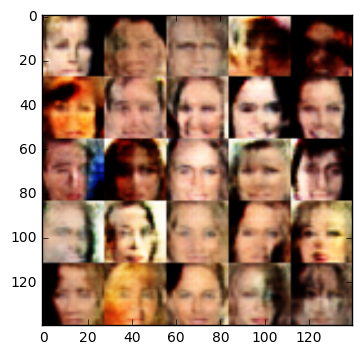

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.9687


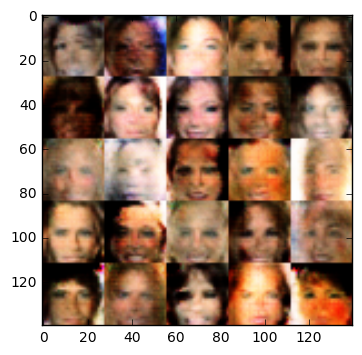

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 1.2152


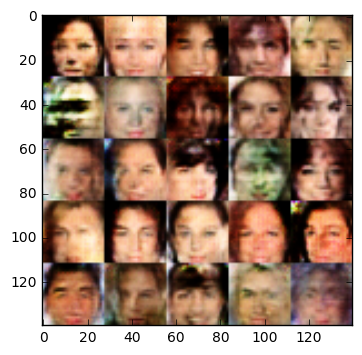

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0043


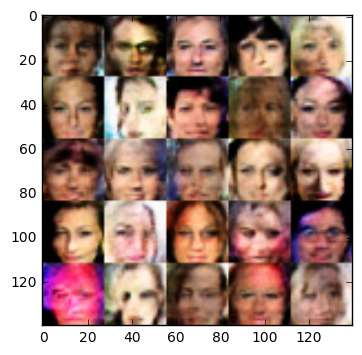

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.9752... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8572


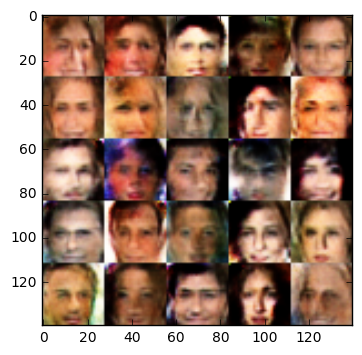

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.6943... Generator Loss: 0.2953
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6248


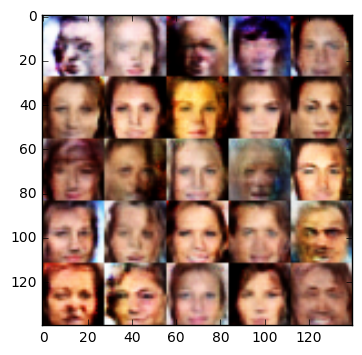

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5781


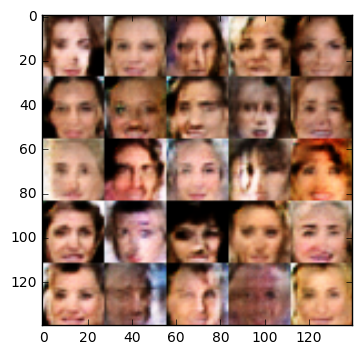

Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6816


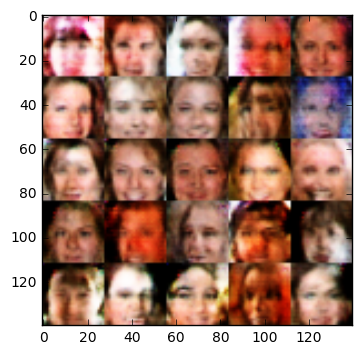

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6331


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.